<a href="https://colab.research.google.com/github/intanelaqsha/Climatologies/blob/main/Ozon_Hole_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install cartopy
!pip install cdsapi

In [39]:
import numpy as np #linear algebra package
import matplotlib  #provide plotting routines
import matplotlib.pyplot as plt #provide plotting routines
import cartopy #for geospatial data analyses
import cartopy.crs as ccrs #The crs module defines Coordinate Reference Systems
import datetime as dt #library that handles the time and date.
import xarray #library used for working with data, provides us with some easy to use data structures. Install also netCDF4 optional dependency here seperately.
import pandas as pd #library used for working with data, we will just a few convenient functions.
import cdsapi #python package that will allow us to make CDS dataset easily available in this notebook here.
import zipfile #to unzip datafiles that are in zip format.
import glob #to collect files in a directory within python

In [42]:
request=[
    "satellite-ozone-v1",
    {"processing_level": "level_3",
    "variable": "atmosphere_mole_content_of_ozone",
    "vertical_aggregation": "total_columns_uv",
    "sensor": ["merged_uv"],
    "year": [
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022", "2023"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "version": ["v2000"]
  }
]

datadir="./datadir"

In [43]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '81abf939-40c2-49ab-b1e6-8b2f02afb534'

In [44]:
c = cdsapi.Client(url=URL,key=KEY)
remote = c.retrieve(*request)
datazipfile=remote.download() #will download the datafiles from the CDS in a zipfile (the name of the zipfile is given by the variable datazipfile) in the current directory.
with zipfile.ZipFile(datazipfile, "r") as zip_ref: #unzip into datadir directory
    zip_ref.extractall(datadir)


2025-11-01 14:34:21,272 INFO Request ID is 7e467da7-5f65-4539-a56a-f9baba04f031
INFO:ecmwf.datastores.legacy_client:Request ID is 7e467da7-5f65-4539-a56a-f9baba04f031
2025-11-01 14:34:21,460 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-01 14:34:35,574 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


555e2bc4067a8d8820be48761f257163.zip:   0%|          | 0.00/672M [00:00<?, ?B/s]

# **Analysis and visualisation of the data**

Making the ozone dataset accessible in our notebook is done by converting the downloaded datafiles to a list of xarray objects by using:

In [45]:
dataset = [
    xarray.open_dataset(f) for f in glob.glob(datadir+"/*.nc")
] #construct a list of xarray objects sorted by date, these objects contains all the information that is in the monthly files.
dataset.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d")) #sort by increasing dates

In [46]:
for x in dataset:
    x['total_ozone_column']=x['total_ozone_column']*x['total_ozone_column'].multiplication_factor_to_convert_to_DU

dataset_mean_long=[x.mean(dim='longitude',skipna=True) for x in dataset]

dataset=xarray.concat(dataset_mean_long,pd.Index([dt.datetime.strptime(x.time_coverage_start,"%Y%m%d") for x in dataset], name='date'))

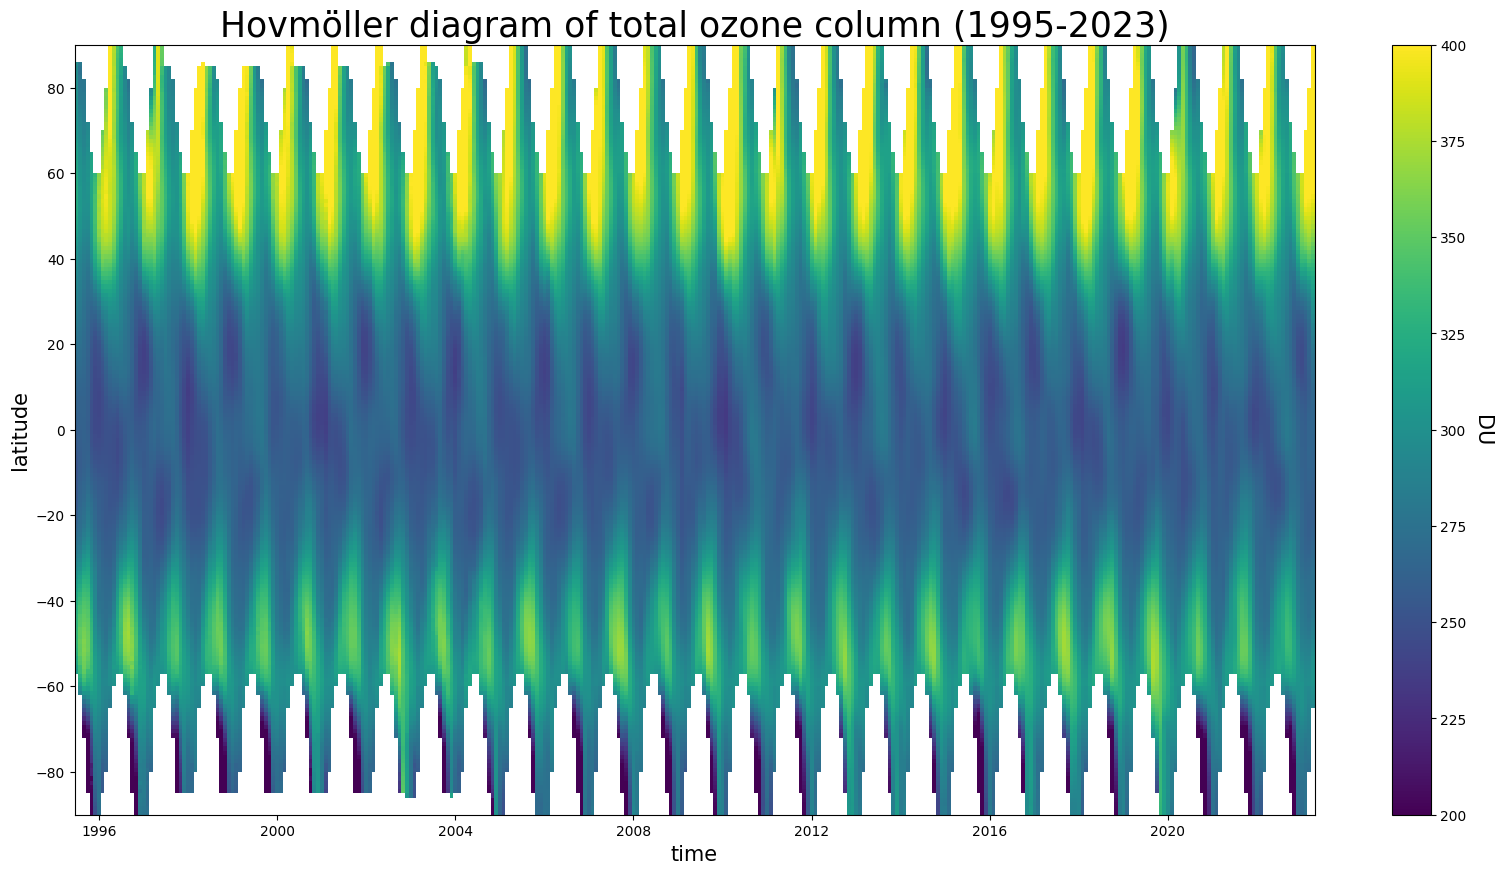

In [47]:
o3plot=dataset['total_ozone_column'].plot(
    x=dataset['total_ozone_column'].dims[0],y=dataset['total_ozone_column'].dims[1],cmap='viridis',
    add_labels=False,add_colorbar=False,size=10,aspect=2.0,vmin=200,vmax=400
)
# the dataset['total_ozone_column'].plot(...) line above deliver a nice figure (technically speaking this is the xarray wrapper of the function *matplotlib.pyplot.pcolormesh*)
#However we want to set our own labels, title and add colorbar, this is done in the code below.
ax = plt.gca() #gives the current axes instance on the current figure, this is needed to provide labels and a title on the plot.
ax.set_xlabel("time", fontsize=15) #xlabel on the figure
ax.set_ylabel("latitude", fontsize=15) #ylabel on the figure
ax.set_title("Hovmöller diagram of total ozone column (1995-2023)", fontsize=25) #title above the figure
cbar = plt.colorbar(o3plot) #this is to attach a colorbar to the plot.
cbar.set_label('DU', rotation=270,fontsize=15,labelpad=18) #placement of the label of the colorbar

# **The evolution of the global ozone distribution during the course of the year 2022**

In [55]:
dataset2=[xarray.open_dataset(f) for f in glob.glob(datadir+"/2022*.nc")]
dataset2.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d"))

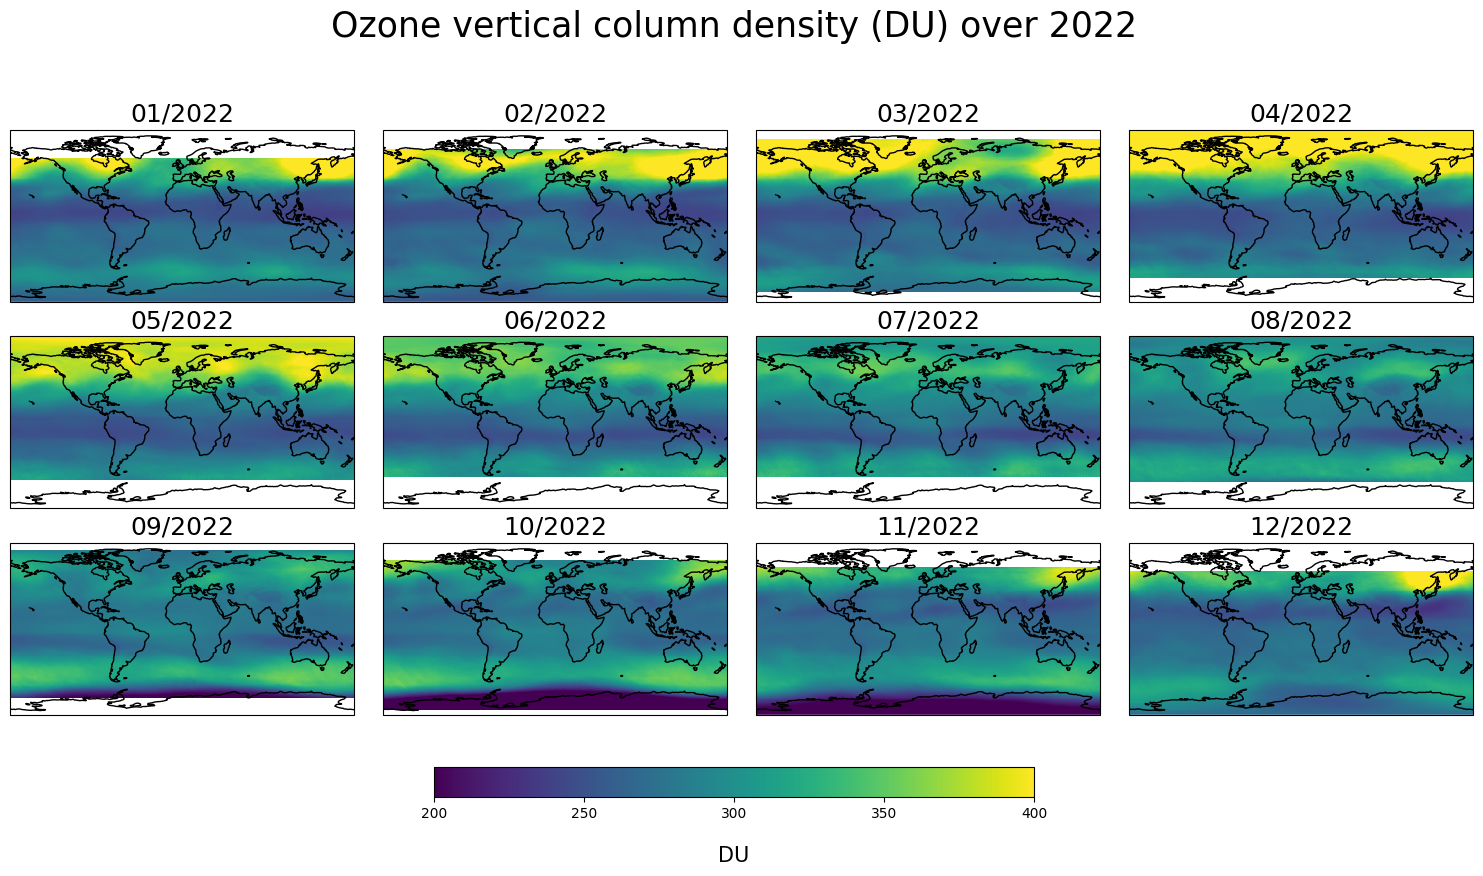

In [56]:
proj=ccrs.PlateCarree() #choose projection
#latitude, longitude boundaries
latlon_bounds=[-180, 180, -90, 90]
# prepare the 12 maps for the different subplots.
figure, axs = plt.subplots(nrows=3,ncols=4,figsize=(15,15),subplot_kw={'projection': proj})
axs=axs.flatten() #needed to be able to loop in the next line over the axes.
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree()) #method to set the boundaries
figure.suptitle("Ozone vertical column density (DU) over 2022",fontsize=25) #main title
for i,data in enumerate(dataset2): #loop over the monthly total ozone column data
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU #conversion to Dobson units.
    #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further.
    lat=data['latitude'].to_numpy() #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further.
    long=data['longitude'].to_numpy() #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further.
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d") #extracting the date
    datstr=dt.datetime.strftime(dat,"%m/%Y") #month/year structure
    axs[i].coastlines() #adding lines around the coasts.
    axs[i].set_title('{}'.format(datstr),fontsize=18) # update title of each subplot with attribute time_coverage_start, formatted as month/year.
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400) #plotting routine to colour the map according to
    #the ozone distributions.
figure.subplots_adjust(bottom=0.51, top=0.9, left=0.01, right=1.0,wspace=0.02, hspace=0.2) #positioning of the different subplots.
cbar_ax = figure.add_axes([0.3, 0.455, 0.4, 0.02]) #positioning of the colorbar.
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal') #add a colorbar
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18) #label for the colorbar
plt.show()

# **The evolution of the ozone hole above Antarctica**

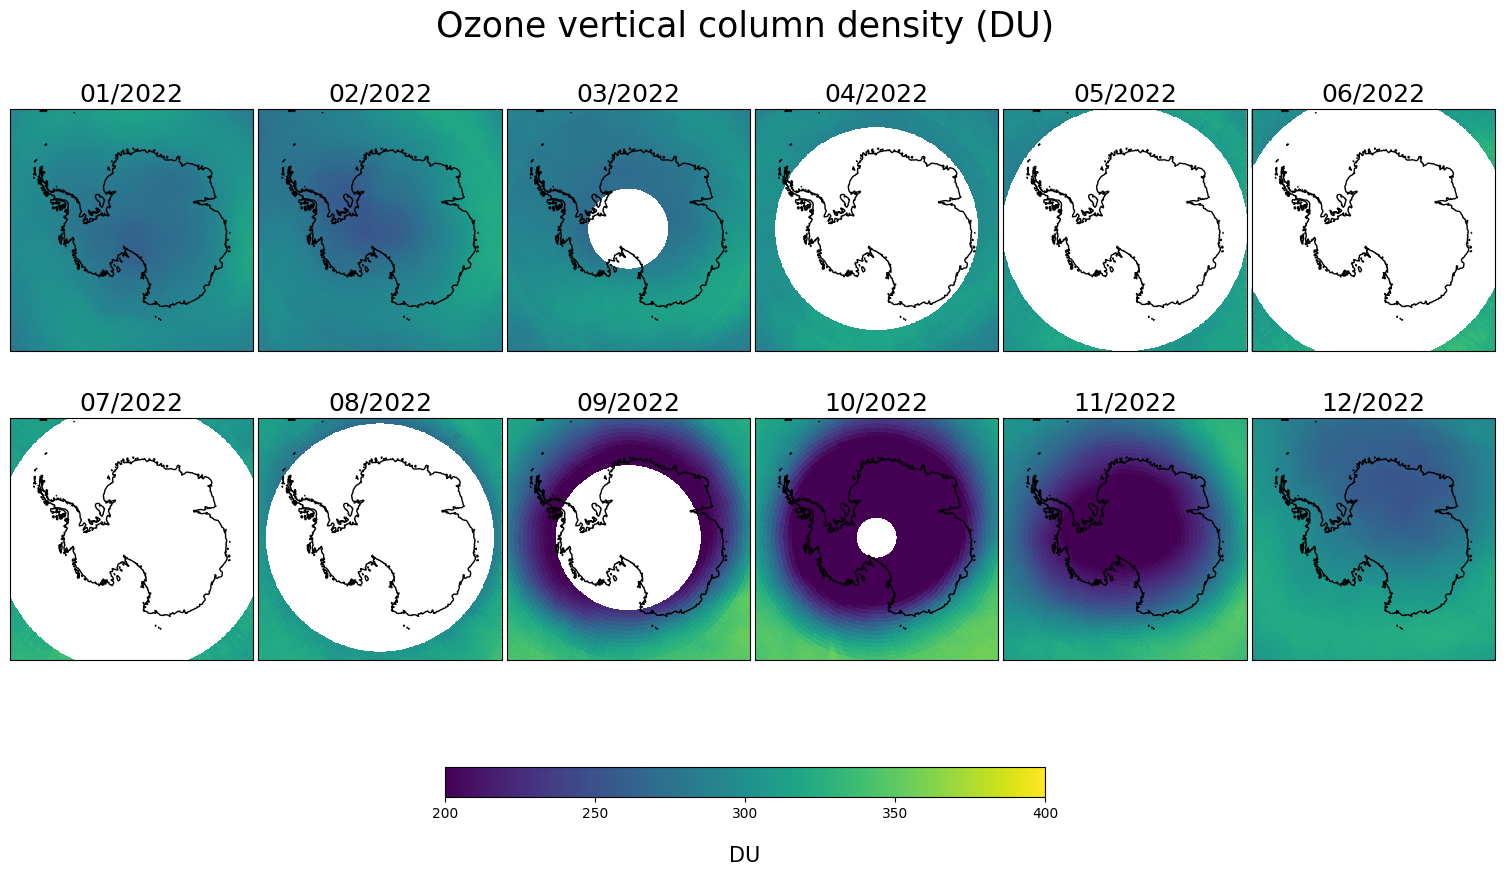

In [57]:
proj=ccrs.SouthPolarStereo() #choose projection
latlon_bounds=[-180, 180, -90, -60] #latitude, longitude boundaries
figure, axs = plt.subplots(nrows=2,ncols=6,figsize=(15,15),subplot_kw={'projection': proj});
axs=axs.flatten()
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree())
figure.suptitle("Ozone vertical column density (DU)",fontsize=25)
for i,data in enumerate(dataset2):
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU
    lat=data['latitude'].to_numpy()
    long=data['longitude'].to_numpy()
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d")
    datstr=dt.datetime.strftime(dat,"%m/%Y")
    axs[i].coastlines()
    axs[i].set_title('{}'.format(datstr),fontsize=18)
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400)
figure.subplots_adjust(bottom=0.51, top=0.95, left=0.01, right=1.0,wspace=0.02, hspace=-0.12)
cbar_ax = figure.add_axes([0.3, 0.455, 0.4, 0.02])
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal')
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18)
plt.show()

# **Time series of the ozone hole over the years in the polar projection during October**

In [51]:
dataset3=[xarray.open_dataset(f) for f in glob.glob(datadir+"/????10*.nc")] #extract the files from each year of the month October and create xarray objects.
dataset3.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d"))

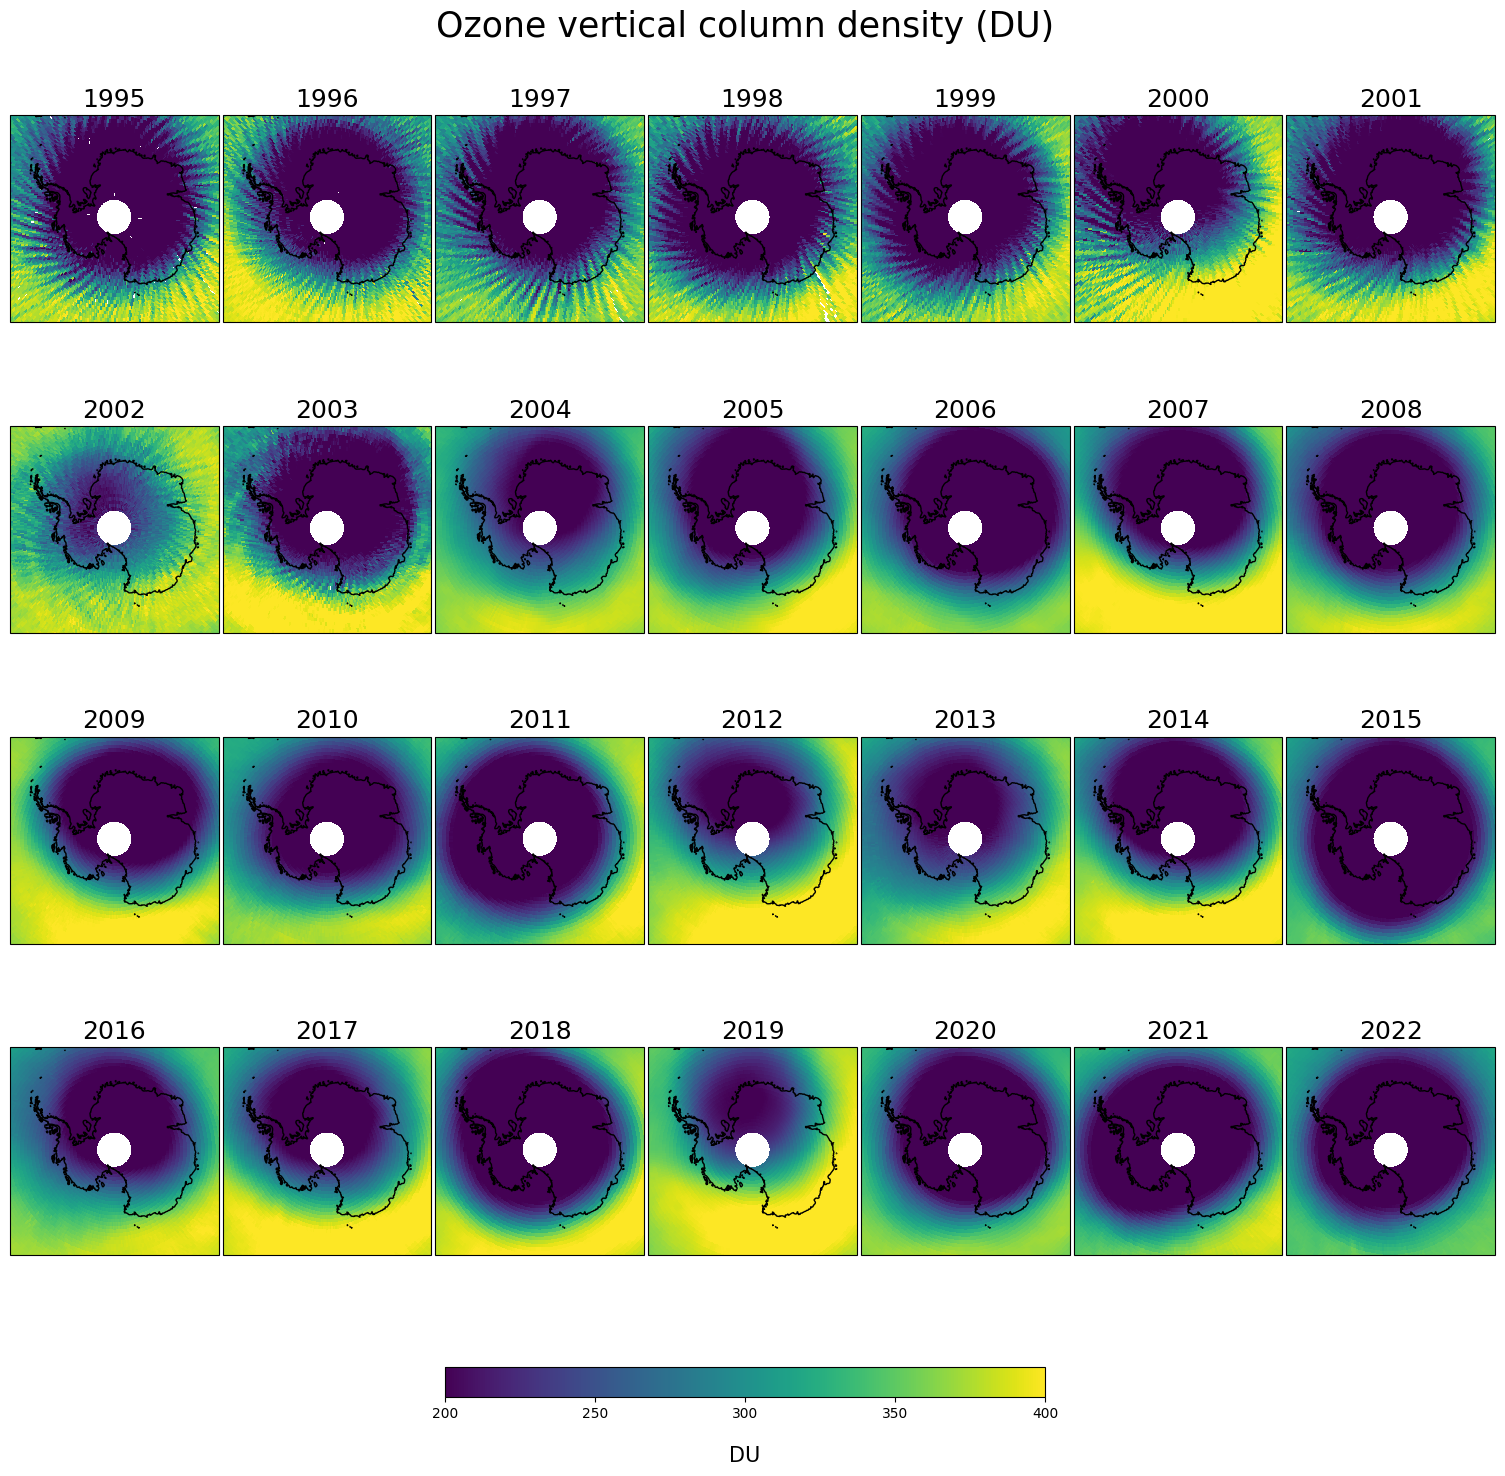

In [52]:
proj=ccrs.SouthPolarStereo() #choose projection
latlon_bounds=[-180, 180, -90, -60] #latitude, longitude boundaries
figure, axs = plt.subplots(nrows=4,ncols=7,figsize=(15,15),subplot_kw={'projection': proj});
axs=axs.flatten()
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree())
figure.suptitle("Ozone vertical column density (DU)",fontsize=25)
for i,data in enumerate(dataset3):
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU
    lat=data['latitude'].to_numpy()
    long=data['longitude'].to_numpy()
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d")
    datstr=dt.datetime.strftime(dat,"%Y")
    axs[i].coastlines()
    axs[i].set_title('{}'.format(datstr),fontsize=18)
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400)
figure.subplots_adjust(top=0.95, left=0.01, right=1.0,wspace=0.02, hspace=-0.05)
cbar_ax = figure.add_axes([0.3, 0.055, 0.4, 0.02])
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal')
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18)
plt.show()